# Building a Private AI Chatbot with PDFs

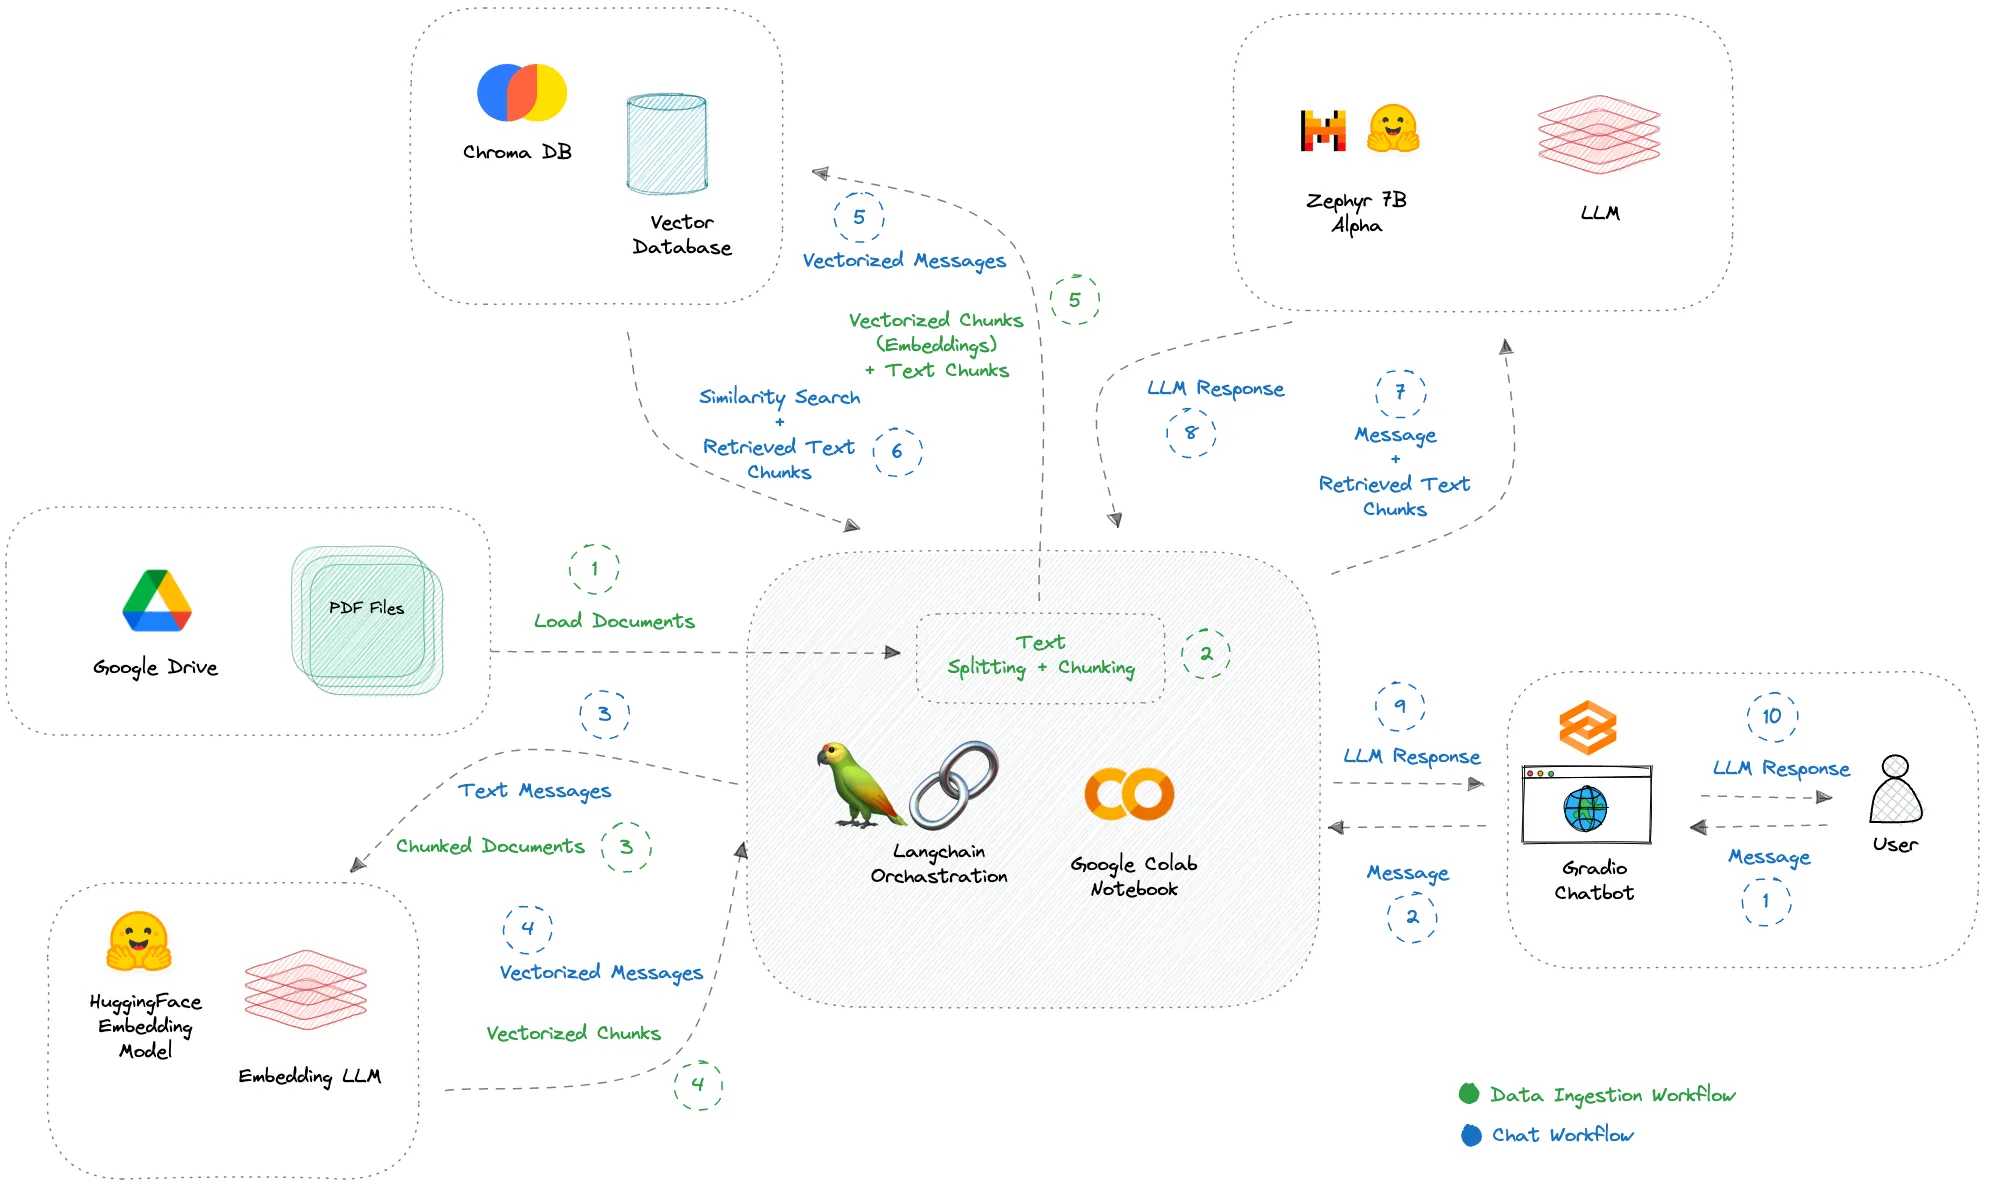

# Importing Packages

In [1]:
# import dependencies
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline

import os

from langchain.vectorstores import Chroma
from langchain.llms import HuggingFacePipeline
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain import HuggingFacePipeline
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory

C:\Users\Administrator\anaconda3\envs\alaa_ai_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from deep_translator import GoogleTranslator

# Download the Model from HuggingFace:
download the Zephyr-7B-Alpha model

In [3]:
# specify model huggingface mode name
model_name = "anakin87/zephyr-7b-alpha-sharded"

# function for loading 4-bit quantized model
def load_quantized_model(model_name: str):
    """
    :param model_name: Name or path of the model to be loaded.
    :return: Loaded quantized model.
    """
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        quantization_config=bnb_config
    )
    return model

In [4]:
# fucntion for initializing tokenizer
def initialize_tokenizer(model_name: str):
    """
    Initialize the tokenizer with the specified model_name.

    :param model_name: Name or path of the model for tokenizer initialization.
    :return: Initialized tokenizer.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.bos_token_id = 1  # Set beginning of sentence token id
    return tokenizer

In [5]:
# load model
model = load_quantized_model(model_name)

# initialize tokenizer
tokenizer = initialize_tokenizer(model_name)

# specify stop token ids
stop_token_ids = [0]

`low_cpu_mem_usage` was None, now set to True since model is quantized.
Loading checkpoint shards: 100%|██████████| 8/8 [02:03<00:00, 15.43s/it]


In [6]:
# load pdf files
loader = PyPDFDirectoryLoader("pdfs")
documents = loader.load()

In [7]:
# split the documents in small chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100) #Chage the chunk_size and chunk_overlap as needed
all_splits = text_splitter.split_documents(documents)

In [8]:
# specify embedding model (using huggingface sentence transformer)
#embedding_model_name = "sentence-transformers/all-mpnet-base-v2"
embedding_model_name = "intfloat/multilingual-e5-large"
model_kwargs = {"device": "cuda"}
embeddings = HuggingFaceEmbeddings(model_name=embedding_model_name, model_kwargs=model_kwargs)

In [9]:
#embed document chunks
vectordb = Chroma.from_documents(documents=all_splits, embedding=embeddings, persist_directory="chroma_db_multilingual")

In [10]:
# specify the retriever
retriever = vectordb.as_retriever()

In [11]:
# build huggingface pipeline for using zephyr-7b-alpha
pipeline = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        use_cache=True,
        device_map="auto",
        max_length=2048,
        do_sample=True,
        top_k=5,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
)

In [12]:
# specify the llm
llm = HuggingFacePipeline(pipeline=pipeline)

In [13]:
# build conversational retrieval chain with memory (rag) using langchain
def create_conversation(query: str, chat_history: list) -> tuple:
    try:

        memory = ConversationBufferMemory(
            memory_key='chat_history',
            return_messages=False
        )
        qa_chain = ConversationalRetrievalChain.from_llm(
            llm=llm,
            retriever=retriever,
            memory=memory,
            get_chat_history=lambda h: h,
        )

        result = qa_chain({'question': query, 'chat_history': chat_history})
        chat_history.append((query, result['answer']))
        return '', chat_history


    except Exception as e:
        chat_history.append((query, e))
        return '', chat_history

In [65]:
user_prompt = GoogleTranslator(source='auto', target='en').translate(input("User: "))

User:  صح أم خطأ "ل ٌشمل مصطلح اإلعالات المتعددة اإلعالة البصرٌة السمعٌة"


In [66]:
result = create_conversation(user_prompt , [])

In [67]:
print(result)

('', [('True or False “The term multimedia does not include audio-visual media”', "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.\n\n9-  A  student  with  multiple  disabilities  must  be  taught  through  the  procedures  learned  with  each  dependency.  One  of  the  error  criteria  must  also  \nbe  met\n71-  We  fall  under  developmental  delay........  main  areas\nNeurodevelopmental  disorders\n5.  Developmental  supports  for  infants  or  young  students  require  the  combined  efforts  of  multiple  experts  (one  from  each  specific  support  area)  FalsePart  Fourteen  Exam  (Final  Exam)\nDevelopment  support\nDevelopmental  disorders  at  work\n12\n6-  The  term  multimedia  does  not  include  audio-visual  mediaDevelopmental  delay\n7-  The  term  “specific  learning  difficulties”  includes  conditions  such  as  cognitive  difficulties,  brain  injur

In [68]:
start  = result[1][0][1].find('\nHelpful Answer: ')
#end = result[1][0][1].find('\n\n.')
substring = result[1][0][1][start:].strip()

In [69]:
my_string = substring
my_list = my_string.split()
print(my_list)

['Helpful', 'Answer:', 'True', 'Question:', 'True', 'or', 'False', '“The', 'line', 'of', 'developmental', 'delay', 'is', 'constant', 'across', 'frequent', 'cultural', 'and', 'technological', 'changes”', 'Helpful', 'Answer:', 'False', 'Question:', 'True', 'or', 'False', '“The', 'first', 'part', 'of', 'the', 'developmental', 'delay', 'battery', 'will', 'be', 'used', 'to', 'determine', 'the', 'path', 'on', 'the', 'severe', 'and', 'multiple', 'dependency', 'assessment', 'scale”', 'Helpful', 'Answer:', 'True', 'Question:', 'True', 'or', 'False', '“Classifications', 'used', 'for', 'older', 'children', '–', 'school', 'age', '–', 'are', 'often', 'inappropriate', 'for', 'younger', 'children”', 'Helpful', 'Answer:', 'True', 'Question:', 'Which', 'of', 'the', 'following', 'is', 'an', 'outcome', 'of', "Lannon's", 'Teaching', 'Individuals', 'with', 'Difficulties', 'included', 'in', 'Part', 'B?', 'Helpful', 'Answer:', 'Outcomes,', 'objectives,', 'and', 'definitions', 'of', 'incorrectly', 'used', 'te

In [70]:
[i for i, j in enumerate(my_list) if j == 'Answer:']

[1, 21, 51, 73, 94, 128, 148, 180, 217, 268, 318, 358, 396, 426, 479, 520, 544]

In [72]:
my_list[545]

'A'